In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

pd.set_option('display.max_columns', None)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

In [3]:
drops = gpd.read_parquet('data/realFakeDrops.parquet')
drops

,dropID,vendor,tail_number,inc_name,inc_num,viirs_fireid,mtbs_eventID,false_pos,split_drop,IA_drop,AC_type,fluid,nonfire,knots,heading_true,alt_feet,gallons,geometry,latitude,longitude,line_length_mile,shape_length,drop_minute,drop_second,UTC_date_time,local_date,local_year,local_month,local_day,local_tz,local_hour,burn_severity,gm_pdsi,gm_srad,gm_vpd,aw_mat,aw_mcmt,aw_mwmt,aw_td,dem,dem_slope,dem_aspect,dem_flow_acc,landfire_fvt,landfire_fbfm40,biomass_afg,biomass_pfg,ndvi,dm_tmax,dm_tmin,hillshade,prev_area,gallon_sum,prev_perimID,fut_perimID,ros_before,ros_after,ros_change,efficacy_mean,real_drop
0,T-01_2018_173_00:44:34,latitude,T-01,GRAHAM 0420 OD,2018-OR955S-000420,F7767,OR4453912142620180621,NO,NO,YES,LAT,,,157.0,95.0,3110.0,2912.0,"MULTILINESTRING ((-1989720.393 2663595.103, -1...",44.553985,-121.403362,0.255131,410.593758,44,34,2018-06-22 00:44:34,43272.0,2018.0,6.0,21.0,America/Los_Angeles,17.0,1.850000,-5.260001,322.700043,1.320000,9.399999,0.400000,19.899998,19.500000,881.650024,11.082952,171.945786,23.650000,2424.250000,130.050003,418.399994,665.900024,0.27543,17.633585,4.864350,203.900000,6.539376e+06,22958.0,F7767_1,F7767_2,188.125000,0.000000,-188.125000,slowed,True
1,T-01_2018_173_01:24:10,latitude,T-01,GRAHAM 0420 OD,2018-OR955S-000420,F7767,OR4453912142620180621,NO,NO,YES,LAT,,,160.0,70.0,3018.0,2912.0,"MULTILINESTRING ((-1988457.392 2663538.622, -1...",44.556490,-121.387805,0.256315,412.499112,24,10,2018-06-22 01:24:10,43272.0,2018.0,6.0,21.0,America/Los_Angeles,18.0,1.600000,-5.260000,322.700012,1.320000,9.500000,0.500000,20.000000,19.500000,857.000000,16.557856,190.126877,8.400000,2054.800049,144.199997,336.200012,619.599976,0.24820,17.907667,4.975000,223.200000,6.539376e+06,22958.0,F7767_1,F7767_2,290.833333,0.000000,-290.833333,slowed,True
2,T-01_2018_173_02:09:44,latitude,T-01,GRAHAM 0420 OD,2018-OR955S-000420,F7767,OR4453912142620180621,NO,NO,YES,LAT,,,162.0,42.0,2962.0,2933.0,"MULTILINESTRING ((-1987696.874 2663489.501, -1...",44.557867,-121.378387,0.257586,414.544619,09,44,2018-06-22 02:09:44,43272.0,2018.0,6.0,21.0,America/Los_Angeles,19.0,2.000000,-5.260001,322.700043,1.320000,9.500000,0.500000,20.000000,19.500000,820.099976,20.405041,163.503204,7.500000,2049.399902,125.250000,377.700012,592.599976,0.24820,17.062267,4.645667,226.350000,6.539376e+06,22958.0,F7767_1,F7767_2,368.333333,0.000000,-368.333333,slowed,True
3,T-01_2018_173_02:43:15,latitude,T-01,GRAHAM 0420 OD,2018-OR955S-000420,F7767,OR4453912142620180621,NO,NO,YES,LAT,,,145.0,68.0,2834.0,2885.0,"MULTILINESTRING ((-1987277.378 2663826.468, -1...",44.561778,-121.374403,0.290613,467.697509,43,15,2018-06-22 02:43:15,43272.0,2018.0,6.0,21.0,America/Los_Angeles,19.0,1.000000,-4.770000,320.600006,1.350000,9.500000,0.500000,20.000000,19.500000,757.000000,12.101923,161.385498,3.000000,2080.000000,122.000000,172.000000,606.000000,0.24820,17.036333,4.636000,212.000000,6.539376e+06,22958.0,F7767_1,F7767_2,427.045455,0.000000,-427.045455,slowed,True
4,T-01_2018_174_21:19:28,latitude,T-01,BOXCAR 0410 RN,2018-ORPRD-000410,F7768,OR4516012107120180621,NO,NO,NO,LAT,,,148.0,261.0,1282.0,2906.0,"MULTILINESTRING ((-1945648.834 2723113.575, -1...",45.173840,-121.062320,0.332562,535.208456,19,28,2018-06-23 21:19:28,43274.0,2018.0,6.0,23.0,America/Los_Angeles,14.0,2.250000,-4.040000,335.500000,1.480000,11.199999,1.200000,22.500000,21.300001,339.937500,15.591919,193.330643,3.218750,2154.000000,114.343750,719.312500,285.375000,0.24980,20.497416,6.278083,210.687500,2.061742e+08,29578.0,F7768_4,None,42.500000,0.000000,-42.500000,persistant,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,None,None,None,None,None,F12981,OR4417212223120200908,None,None,None,None,None,None,NaN,NaN,NaN,NaN,"LINESTRING (-2064359.847 2642539.84, -2064573....",NaN,NaN,0.138922,223.573277

In [4]:
predictColumns = [
    'gm_pdsi','gm_srad','line_length_mile',
    'gm_vpd','aw_mat','aw_mcmt','aw_mwmt','aw_td','dem','dem_slope',
    'dem_aspect','dem_flow_acc','landfire_fvt','landfire_fbfm40',
    'biomass_afg','biomass_pfg','ndvi','dm_tmax','dm_tmin',
    'prev_area','hillshade','real_drop'
]
nice_features_list = [
    'Palmer Drought Severity Index','Solar Radiation','Drop Length',
    'Vapor Pressure Deficit','Mean Annual Temp','Mean Temp Coldest Month',
    'Mean Temp Warmest Month','Temp Difference','Elevation','Slope',
    'Aspect','Flow Accumulation','LANDFIRE Vegetation Type','LANDFIRE Fuels Model 40',
    'Annual Herbaceous Biomass','Perennial Herbaceous Biomass','NDVI','Max Temp','Min Temp',
    'Previous Area of Fire','Hillshade','Real Drop Flag']

nice_features_dict = {}

for i in range(len(predictColumns)-1):
    nice_features_dict[predictColumns[i]] = nice_features_list[i]
nice_features_dict['real_drop_True'] = 'Real Drop Flag'

In [5]:
realDrops = drops.loc[drops.real_drop]
fakeDrops = drops.loc[~drops.real_drop]

len(fakeDrops.viirs_fireid.unique()), len(realDrops.viirs_fireid.unique())

(31, 31)

In [6]:
n = len(realDrops.viirs_fireid.unique())
numDrops = len(realDrops)
realValidIDs = np.random.choice(realDrops.viirs_fireid.unique(), size=n//3, replace=False)
realValidIDs = [
    'F11359', 'F11067', 'F8994', 'F12987', 'F10329', 
    'F9132', 'F12241', 'F9130', 'F13201', 'F14477', 
]
realValidNum = len(realDrops.loc[realDrops.viirs_fireid.isin(realValidIDs)])
realValidNum/numDrops*100

33.617747440273035

In [7]:
n = len(fakeDrops.viirs_fireid.unique())
numDrops = len(fakeDrops)
fakeValidIDs = np.random.choice(fakeDrops.viirs_fireid.unique(), size=n//3, replace=False)
fakeValidIDs = [
    'F12984', 'F12963', 'F14266','F11231', 'F9219', 'F15297', 'F17009', 'F11644', 'F11107', 'F7760'
]
fakeValidNum = len(fakeDrops.loc[fakeDrops.viirs_fireid.isin(fakeValidIDs)])
fakeValidNum/numDrops*100

31.91126279863481

In [8]:
numDrops = len(drops)
validationIDs = list(fakeValidIDs) + list(realValidIDs)
validNum = len(drops.loc[drops.viirs_fireid.isin(validationIDs)])
validNum/numDrops*100

32.76450511945392

In [9]:
validationDrops = drops.loc[drops.viirs_fireid.isin(validationIDs)]
trainDrops = drops.loc[~drops.viirs_fireid.isin(validationIDs)]
len(trainDrops)/len(drops)*100

67.23549488054607

In [10]:
x = drops[predictColumns]
y = drops.efficacy_mean
x_train = x.loc[trainDrops.index]
y_train = y.loc[trainDrops.index]
x_test = x.loc[validationDrops.index]
y_test = y.loc[validationDrops.index]
x_train.head()

,gm_pdsi,gm_srad,line_length_mile,gm_vpd,aw_mat,aw_mcmt,aw_mwmt,aw_td,dem,dem_slope,dem_aspect,dem_flow_acc,landfire_fvt,landfire_fbfm40,biomass_afg,biomass_pfg,ndvi,dm_tmax,dm_tmin,prev_area,hillshade,real_drop
0,-5.260001,322.700043,0.255131,1.32,9.399999,0.4,19.899998,19.500000,881.650024,11.082952,171.945786,23.65000,2424.250000,130.050003,418.399994,665.900024,0.27543,17.633585,4.864350,6.539376e+06,203.9000,True
1,-5.260000,322.700012,0.256315,1.32,9.500000,0.5,20.000000,19.500000,857.000000,16.557856,190.126877,8.40000,2054.800049,144.199997,336.200012,619.599976,0.24820,17.907667,4.975000,6.539376e+06,223.2000,True
2,-5.260001,322.700043,0.257586,1.32,9.500000,0.5,20.000000,19.500000,820.099976,20.405041,163.503204,7.50000,2049.399902,125.250000,377.700012,592.599976,0.24820,17.062267,4.645667,6.539376e+06,226.3500,True
3,-4.770000,320.600006,0.290613,1.35,9.500000,0.5,20.000000,19.500000,757.000000,12.101923,161.385498,3.00000,2080.000000,122.000000,172.000000,606.000000,0.24820,17.036333,4.636000,6.539376e+06,212.0000,True
4,-4.040000,335.500000,0.332562,1.48,11.199999,1.2,22.500000,21.300001,339.937500,15.591919,193.330643,3.21875,2154.000000,114.343750,719.312500,285.375000,0.24980,20.497416,6.278083,2.061742e+08,210.6875,True


In [11]:
cat_features = ['real_drop']
num_features_prep = [item for item in predictColumns if item not in cat_features]

In [12]:
cat_processor = Pipeline(steps=[
    ('encoder',OneHotEncoder(handle_unknown='ignore',drop='if_binary'))    
])
num_processor_prep = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])
feature_processor_prep = ColumnTransformer(transformers=[
    ('num',num_processor_prep,num_features_prep),
    ('cat',cat_processor,cat_features)
])
pipe_prep = Pipeline(steps=[
    ('feature_processor',feature_processor_prep),
    ('model',RandomForestClassifier(random_state=42))
])
parameters = {"model__class_weight" : ['balanced',None] ,
              "model__min_samples_leaf" : [1, 4, 8], 
              "model__min_samples_split" : [2, 8, 12], 
              "model__n_estimators" : [10, 100, 150], 
              "model__max_depth" : [2,10,None]
             }
grid_prep = GridSearchCV(pipe_prep, 
                    parameters,
                    scoring='balanced_accuracy',
                    n_jobs=-1,
                    verbose=True)
grid_prep.fit(x_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['gm_pdsi',
                                                                          'gm_srad',
                                                                          'line_length_mile',
                                                                          'gm_vpd',
                                                                          'aw_mat',
                                                                          'aw_mcmt',
                                                                          'aw_mwmt',
                                                                          'aw_td',
                                                                          'dem',
                                                                          'dem_slope',
                                                                          'dem_aspect',
                                                                          'dem_flow_acc',
                                                                          'landfire_fvt',
                                                                          'landfire_fbfm40',
                                                                          'biomass_afg...
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['real_drop'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__class_weight': ['balanced', None],
                         'model__max_depth': [2, 10, None],
                         'model__min_samples_leaf': [1, 4, 8],
                         'model__min_samples_split': [2, 8, 12],
                         'model__n_estimators': [10, 100, 150]},
             scoring='balanced_accuracy', verbose=True)

In [13]:
grid_prep.best_params_

{'model__class_weight': 'balanced',
 'model__max_depth': 2,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [14]:
estimator_prep = grid_prep.best_estimator_
y_test_pred_prep = estimator_prep.predict(x_test)
balanced_accuracy_score(y_test, y_test_pred_prep)

np.float64(0.8047201336675021)

In [15]:
accuracy_score(y_test, y_test_pred_prep)

0.8567708333333334

(array([0, 1]), [Text(0, 0, 'persistant'), Text(0, 1, 'slowed')])

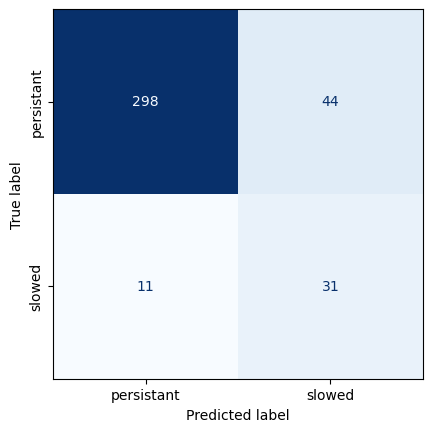

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred_prep,
                                        #normalize='true',
                                        colorbar=False,
                                       cmap='Blues')
plt.yticks(rotation=90, va='center')
#plt.savefig('images/full_conf_matrix.png',dpi=300, bbox_inches="tight")

(array([0, 1]), [Text(0, 0, 'persistant'), Text(0, 1, 'slowed')])

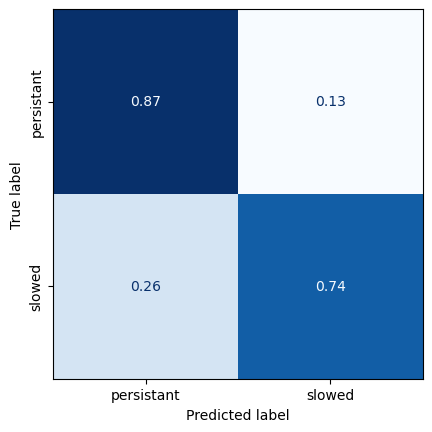

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred_prep,
                                        normalize='true',
                                        colorbar=False,
                                       cmap='Blues')
plt.yticks(rotation=90, va='center')
#plt.savefig('images/full_conf_matrix.png',dpi=300, bbox_inches="tight")

In [18]:
rf_model = estimator_prep.named_steps['model']
importances = rf_model.feature_importances_
feature_processor_prep.fit(x_train)
feature_names = feature_processor_prep.get_feature_names_out()
feature_names = feature_names.tolist()
feature_names = [name.split('__')[-1] for name in feature_names]

feature_importances = pd.DataFrame({
    'feature_abbr': feature_names,
    'Importance': importances
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances['importance_rank'] = np.arange(1,len(feature_importances)+1)
feature_importances['color'] = 'steelblue'
feature_importances.loc[feature_importances.feature_abbr == 'real_drop_True','color'] = 'orange'
feature_importances['Feature'] = ''

for index,row in feature_importances.iterrows():
    feature_importances.at[index,'Feature'] = nice_features_dict[feature_importances.loc[index,'feature_abbr']]

feature_importances.sample()

,feature_abbr,Importance,importance_rank,color,Feature
15,biomass_pfg,0.025465,15,steelblue,Perennial Herbaceous Biomass


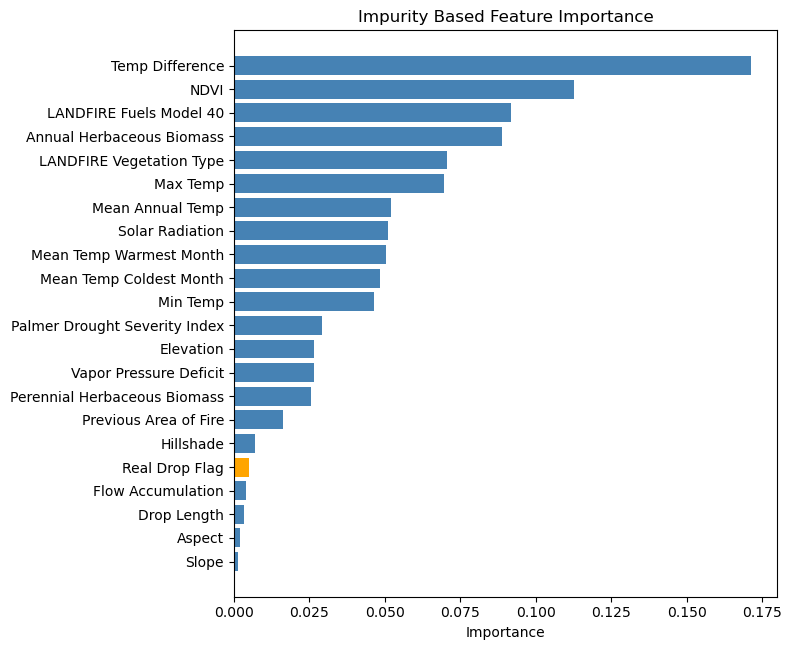

In [19]:
fig, ax = plt.subplots(figsize=(8, len(feature_names) * 0.3)) 
ax.barh(
    feature_importances.Feature, 
    feature_importances.Importance,
    color=feature_importances.color
)
ax.set_xlabel("Importance")
ax.set_title("Impurity Based Feature Importance")
ax.invert_yaxis()  # most important at top
plt.tight_layout()
#plt.savefig('images/feature_importance.png',dpi=300, bbox_inches="tight")
plt.show()

In [20]:
features_dict = {}
for i in range(len(predictColumns)):
    feature = predictColumns[i]
    if feature == 'real_drop':
        feature = 'real_drop_True'
        transformed_feature = 'cat__'+feature
    else:
        transformed_feature = 'num__'+feature
    features_dict[transformed_feature] = nice_features_dict[feature]

In [ ]:
preprocessor = estimator_prep.named_steps['feature_processor']
model = estimator_prep.named_steps['model']
x_test_transformed = preprocessor.transform(x_test)

result = permutation_importance(
    model,
    x_test_transformed,
    y_test,
    scoring='balanced_accuracy',
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

feature_names = estimator_prep.named_steps['feature_processor'].get_feature_names_out()

sorted_idx = result.importances_mean.argsort()[::]

importances = pd.DataFrame(
    result.importances[sorted_idx].T,
    columns=np.array(feature_names)[sorted_idx],
)
importances = importances.rename(columns=features_dict)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

preprocessor = estimator_prep.named_steps['feature_processor']
x_transformed = preprocessor.transform(x)
corr = spearmanr(x_transformed).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=x.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.colorbar(im, ax=ax2,shrink=0.7)
_ = fig.tight_layout()

In [ ]:
limited_features_names = ['aw_td', 'dem', 'hillshade', 'prev_area', 'real_drop']
limited_features_dict = {}
for i in range(len(limited_features_names)):
    feature = limited_features_names[i]
    if feature == 'real_drop':
        feature = 'real_drop_True'
        transformed_feature = 'cat__'+feature
    else:
        transformed_feature = 'num__'+feature
    limited_features_dict[transformed_feature] = nice_features_dict[feature]
    
num_features_limit = list(limited_features_names[:-1])

x_train_limit = x_train[limited_features_names]
x_test_limit = x_test[limited_features_names]

x_train_limit.head()

In [ ]:
num_processor = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])
feature_processor = ColumnTransformer(transformers=[
    ('num',num_processor,num_features_limit),
    ('cat',cat_processor,cat_features)
])
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('model',RandomForestClassifier(random_state=42))
])
grid = GridSearchCV(pipe, 
                    parameters,
                    scoring='balanced_accuracy',
                    n_jobs=-1,
                    verbose=True)
grid.fit(x_train_limit, y_train)

In [ ]:
grid.best_params_

In [ ]:
estimator = grid.best_estimator_
y_test_pred_limit = estimator.predict(x_test_limit)
balanced_accuracy_score(y_test, y_test_pred_limit)

In [ ]:
accuracy_score(y_test, y_test_pred_limit)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred_limit,
                                        normalize='true',
                                        colorbar=False,
                                        cmap='Blues')
plt.yticks(rotation=90, va='center')

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred_limit,
                                        #normalize='true',
                                        colorbar=False,
                                       cmap='Blues')
plt.yticks(rotation=90, va='center')

In [ ]:
preprocessor = estimator.named_steps['feature_processor']
model = estimator.named_steps['model']
x_test_transformed = preprocessor.transform(x_test_limit)

result = permutation_importance(
    model,
    x_test_transformed,
    y_test,
    scoring='balanced_accuracy',
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

feature_names = estimator.named_steps['feature_processor'].get_feature_names_out()

sorted_idx = result.importances_mean.argsort()[::]

importances = pd.DataFrame(
    result.importances[sorted_idx].T,
    columns=np.array(feature_names)[sorted_idx],
)
importances = importances.rename(columns = limited_features_dict)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

plt.savefig('images/permutation_importance.png',dpi=300, bbox_inches="tight")

ax.figure.tight_layout()


In [ ]:
rf_model = estimator.named_steps['model']
importances = rf_model.feature_importances_
feature_processor.fit(x_train_limit)
feature_names = feature_processor.get_feature_names_out()
feature_names = feature_names.tolist()
feature_names = [name.split('__')[-1] for name in feature_names]

feature_importances = pd.DataFrame({
    'feature_abbr': feature_names,
    'Importance': importances
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances['importance_rank'] = np.arange(1,len(feature_importances)+1)
feature_importances['color'] = 'steelblue'
feature_importances.loc[feature_importances.feature_abbr == 'real_drop_True','color'] = 'orange'
feature_importances['Feature'] = ''

for index,row in feature_importances.iterrows():
    feature_importances.at[index,'Feature'] = nice_features_dict[feature_importances.loc[index,'feature_abbr']]

feature_importances

In [ ]:
fig, ax = plt.subplots()#figsize=(8, len(feature_names)*0.8)) 
ax.barh(
    feature_importances.Feature, 
    feature_importances.Importance,
    color=feature_importances.color
)
ax.set_xlabel("Importance")
ax.set_title("Impurity Based Feature Importance")
ax.invert_yaxis()  # most important at top
plt.tight_layout()
plt.savefig('images/feature_importance.png',dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 50))
for i in range(10):
    single_tree = rf_model.estimators_[i]
    plt.subplot(5, 2, i + 1)  # Create a 5x2 grid for the plots
    plot_tree(
        single_tree,
        feature_names=feature_names,  # Replace with actual feature names
        class_names=rf_model.classes_.astype(str),  # Replace with class labels
        filled=True,
        rounded=True,
        ax=plt.gca()  # Plot on the current subplot
    )
plt.tight_layout()
